# 1. Modules

## 1.1. Load basics

In [9]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format='retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import sys
sys.path.append('../../..')

## 1.2. Load library modules

In [75]:
import torch
import numpy as np
import matplotlib.pyplot as plt


from IPython.display import display, clear_output

from magrec import __datapath__
from magrec.prop.Propagator import CurrentPropagator2d, AxisProjectionPropagator, HeightContinuationPadder, ZeroPadder
from magrec.nn.arch import GeneratorCNN
from magrec.misc.load import load_matlab_data
from magrec.misc.plot import plot_n_components

# 2. Data

## 2.1. Load Data¶

We'll be working with the Nb wire dataset, which has three components of the magnetic field known, and known simulated NV orientation angle. There's also a plausible reconstruction available in the notebook `Test_Magnetic_Field_Recon.ipynb`. The goal of this notebook is to achieve a similar or better performance by optimization.

First we load the data and look at what we want to reconstruct the current from:

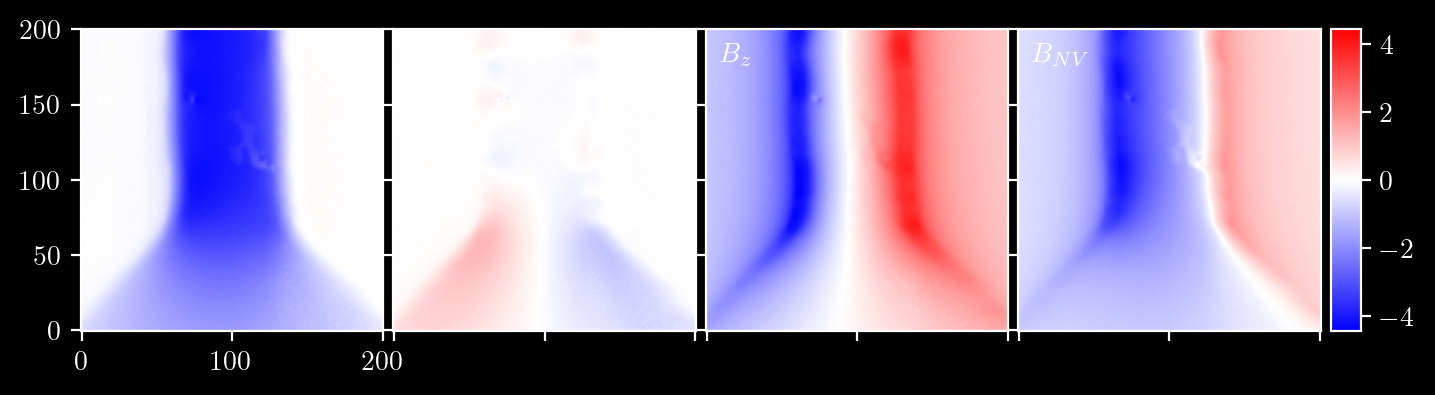

In [63]:
Bx = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bx.txt")
By = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "By.txt")
Bz = np.loadtxt(__datapath__ / "ExperimentalData" / "NbWire" / "Bz.txt")

B = np.empty(shape=(4, 201, 201))

setTheta = np.deg2rad(54.7)
setPhi = np.deg2rad(45)

unv = [np.sin(setTheta) * np.cos(setPhi),
       np.sin(setTheta) * np.sin(setPhi),
       np.cos(setTheta)]

B[0, :, :] = np.flipud(Bx)
B[1, :, :] = np.flipud(By)
B[2, :, :] = np.flipud(Bz)
B[3, :, :] = np.flipud(Bx*unv[0] + By*unv[1] + Bz*unv[2])

plot_n_components(B, labels=[r'$B_x$', '$B_y$',
                  '$B_z$', '$B_{NV}$'], cmap="bwr", show=True)

# Trim B to 200 × 200 so that FFT deals with even dimensions
B = B[:, :200, :200]

## 2.2. Define parameters

In [25]:
dx=0.408  # in μm
dy=0.408

height = 0.015          # μm
layer_thickness = 0.030 # μm

theta = 54.7            # degrees
phi = 30.0              # degrees

# 3. Current reconstruction

## 3.1. Define J → B transformation

In [50]:

shape = (2, 200, 200)
pad1 = HeightContinuationPadder(shape=shape)
pad2 = ZeroPadder(shape=pad1.expanded_shape)
propagator = CurrentPropagator2d(source_shape=pad2.expanded_shape,
                                 dx=dx, dy=dy, height=height, layer_thickness=layer_thickness,)
proj = AxisProjectionPropagator(theta=theta, phi=phi)


def compute_B_NV(J: torch.tensor):
    J = pad1.pad(J)
    J = pad2.pad(J)
    B = propagator(J)
    B = pad2.unpad(B)
    B = pad1.unpad(B)
    B_NV = proj.project(B)
    B = torch.stack([B[0], B[1], B[2], B_NV], dim=0)
    return B


## 3.3. Define net, optimizer, loss function and training loop

In this case, we will be using a neural network to take B, convert it to J through it's net parameters, and calculate the error using `compute_B_NV` above.

In [89]:
# Here we define the loss function and the optimization algorithm
def train_net(net: torch.nn.Module, B, n_iter=1000, plot_interval=100):
    """Run the optimization loop.
    
    Parameters
    ----------
    B : np.ndarray or torch.tensor
        The measured magnetic field to match with a reconstructed current density

    n_iter : int, optional
        Number of iterations, by default 1000

    plot_interval : int, optional
        Number of iterations between each plot, by default 100
    
    Returns
    -------
    J : torch.tensor
        The reconstructed current density
    """ 
    # Define the loss function and the optimizer
    loss_fn = torch.nn.MSELoss()
    optimizer = torch.optim.Adam

    # Add the optimizer to the parameters
    optimizer = optimizer(net.parameters, lr=1.)

    # Convert B to a torch tensor of float32
    B = torch.from_numpy(B).float()
    # Add a batch dimension, since we are optimizing only on one sample
    B = B[None, ...]

    # Initialize a list to track loss and update it on each iteration
    track_loss = []
    fig_loss = plt.figure('Loss')
    fig_loss.suptitle('Loss as a function of iteration')
    fig_loss.supxlabel('Iteration')
    fig_loss.supylabel('Loss')
    
    # Make an axis to plot the loss
    ax_loss = fig_loss.add_subplot(111)

    def show_progress(B_pred, J_rec):
        print(f"Loss at iteration {i}: {loss.item()}")
        fig1 = plot_n_components(J_rec.detach().numpy(), labels=[r'$J_x$', '$J_y$'], cmap="bwr")
        fig2 = plot_n_components(B_pred.detach().numpy(), labels=[r'$B_x$', '$B_y$', '$B_z$', '$B_{NV}$'], cmap="bwr")

        # Plot the loss as a function of iteration
        ax_loss.clear()
        ax_loss.plot(track_loss)

        # Display the output in the notebook and clear the output
        display(fig1)
        display(fig2)
        display(fig_loss)
        clear_output(wait=True)


    # Make a for loop for training to optimize the current J
    for i in range(n_iter):
        # Compute the predicted B_NV
        B_pred = net(B)
        
        # Compute the loss
        loss = loss_fn(B_pred[3], B[3])
        # Add the loss to the list
        track_loss.append(loss.item())
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Compute the gradients
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # Print the loss
        if i % plot_interval == 0:
            show_progress()

        # If the loss is smaller then this value, change the learning rate
        if loss.item() < 1e-9:
            print('Changing learning rate to 1e-1')
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-1

        if loss.item() < 1e-11:
            print('Changing learning rate to 1e-3')
            for param_group in optimizer.param_groups:
                param_group['lr'] = 1e-3
        
        # If the loss is small enough, stop the optimization
        if loss.item() < 1e-13:
            print('Stopping optimization, converged to a loss of < 1e-10')
            show_progress()
            break

    return track_loss

Some info from experiments with running the function above with some parameters:

1. Loss of ≈0.79 corresponds to a not satisfactory result. This loss is achieved in about 3m when learning rate of 1e-1 is used 

Loss at iteration 1200: 3.54393087036442e-05


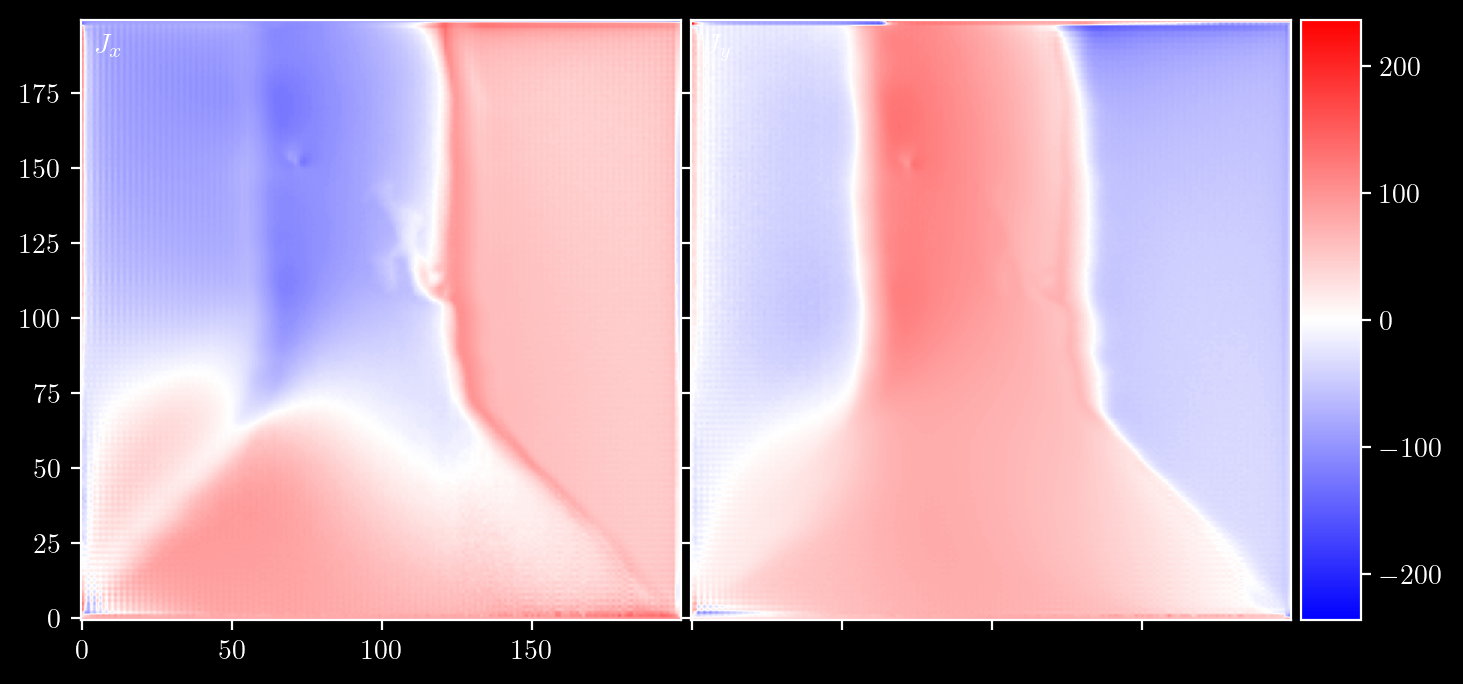

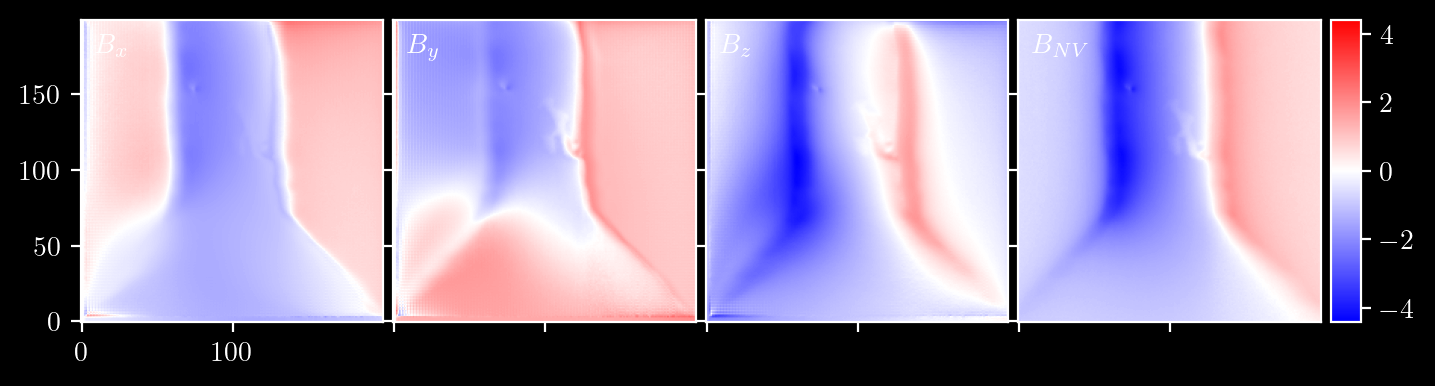

In [90]:
J = run_optimization(B, 10000, 100)